# notebook/04_data

In [1]:
import os
import sys 
import logging

# Caminho para a raiz do seu projeto
project_root = os.path.abspath("..")  # Sobe um nível de pasta a partir de 'notebooks'

# Adiciona o caminho ao sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import functions as F
from config.configs import *
from config.spark_session import create_spark_session

## Spark Session

In [2]:
spark = create_spark_session(HOST_ADDRESS, MINIO_ACCESS_KEY, MINIO_SECRET_KEY)

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-31112ce0-7c1f-4401-a1c8-7aeb80791f25;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central


:: loading settings :: url = jar:file:/opt/bitnami/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.postgresql#postgresql;42.6.0 in central
	found org.checkerframework#checker-qual;3.31.0 in central
:: resolution report :: resolve 106ms :: artifacts dl 4ms
	:: modules in use:
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	org.checkerframework#checker-qual;3.31.0 from central in [default]
	org.postgresql#postgresql;42.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   5   |   0   |   0   |   0   ||   5   |   0   |
	------------------------------------------------------------

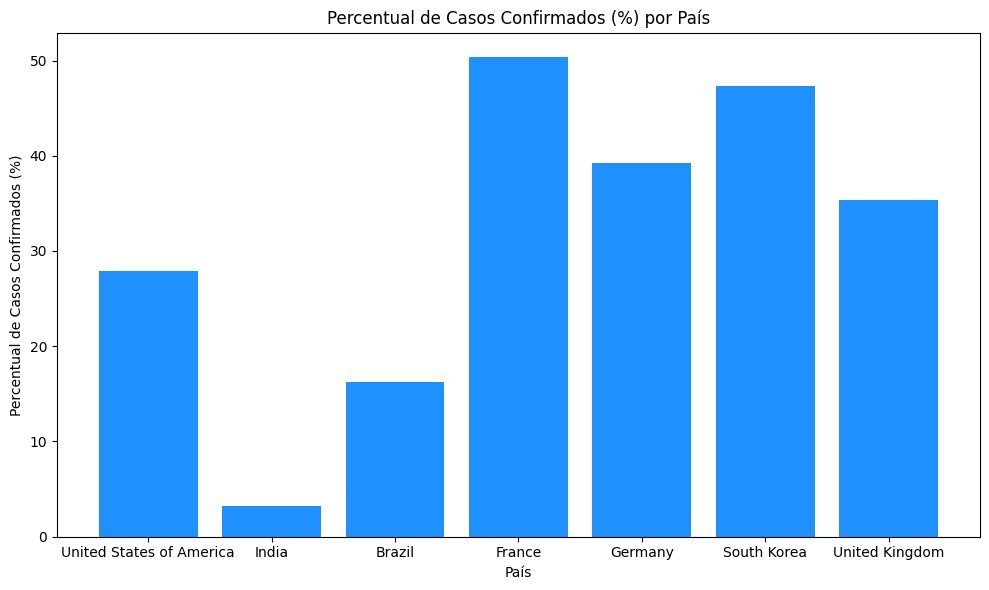

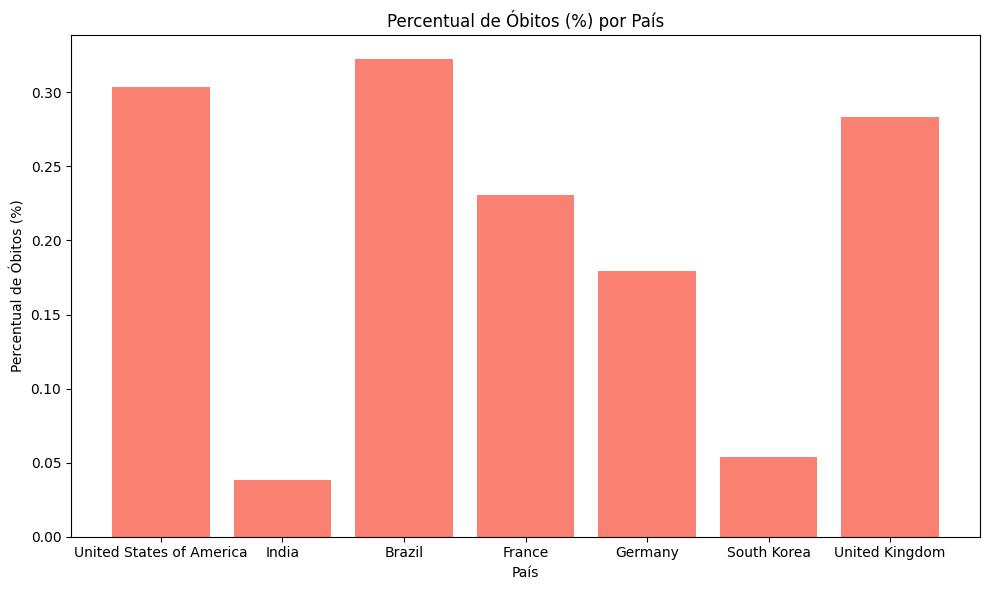

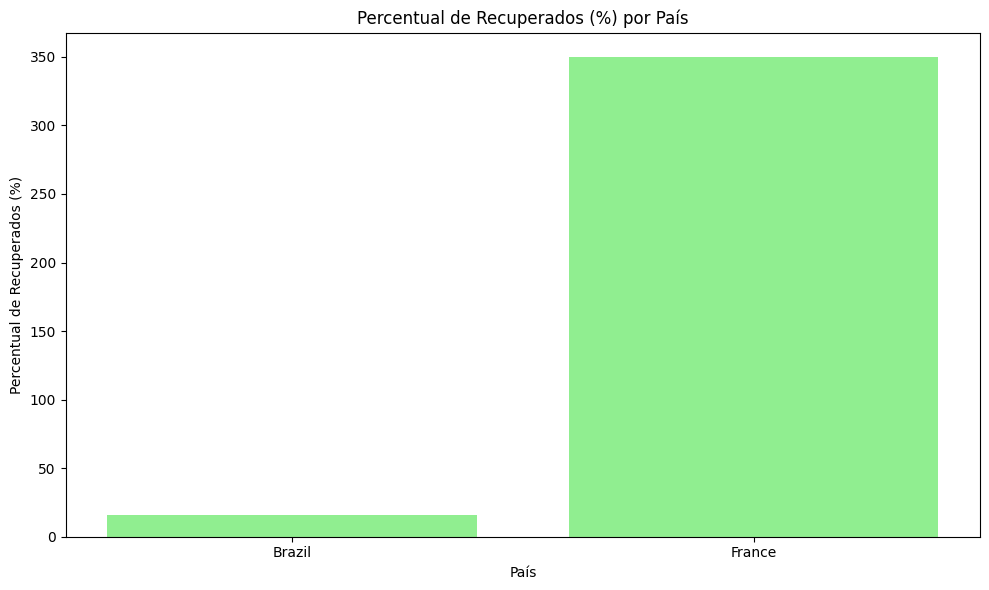

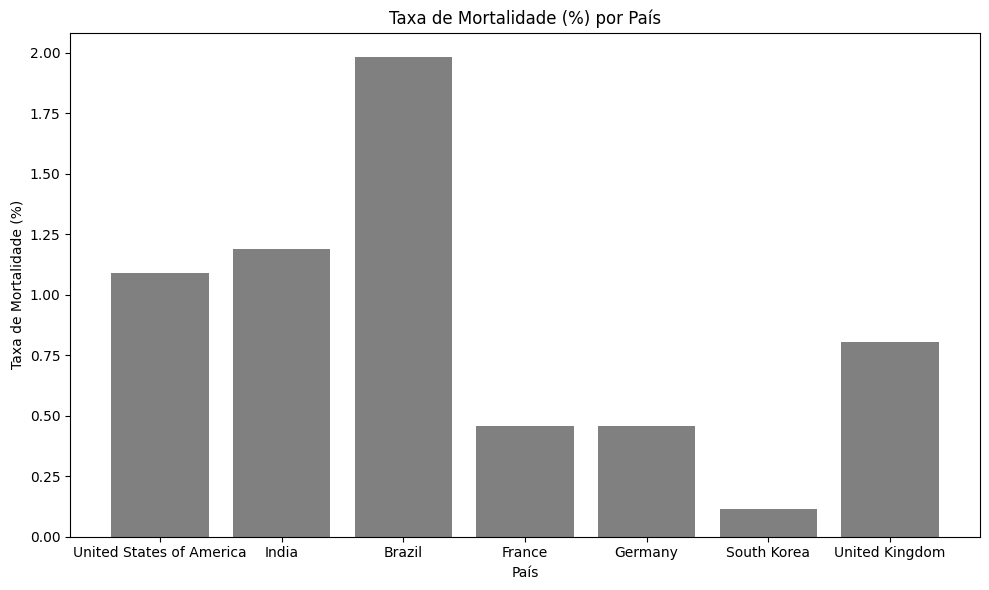

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregar os dados do Delta Lake
df_gold = spark.read.format("delta").load(f's3a://gold/covid19/gold_covid19')

# Seleciona apenas as colunas relevantes para o estudo
df_gold_selected = df_gold.select("country_name", "population", "total_cumulative_confirmed", 
                                  "total_cumulative_deceased", "total_cumulative_recovered")

# Convertendo para Pandas para trabalhar com gráficos
df_gold_pd = df_gold_selected.toPandas()

# Ordena pelo total de casos confirmados e seleciona os 7 países com mais casos
df_top7 = df_gold_pd.nlargest(7, 'total_cumulative_confirmed')

# Calcula os indicadores percentuais
df_top7['percent_confirmed'] = (df_top7['total_cumulative_confirmed'] / df_top7['population']) * 100
df_top7['percent_deceased'] = (df_top7['total_cumulative_deceased'] / df_top7['population']) * 100
df_top7['percent_recovered'] = (df_top7['total_cumulative_recovered'] / df_top7['population']) * 100
df_top7['mortality_rate'] = (df_top7['total_cumulative_deceased'] / df_top7['total_cumulative_confirmed']) * 100

# Lista de indicadores e suas cores para os gráficos
indicators = [
    ('percent_confirmed', 'Percentual de Casos Confirmados (%)', 'dodgerblue'),
    ('percent_deceased', 'Percentual de Óbitos (%)', 'salmon'),
    ('percent_recovered', 'Percentual de Recuperados (%)', 'lightgreen'),
    ('mortality_rate', 'Taxa de Mortalidade (%)', 'grey')
]

# Plotar gráficos comparativos para cada indicador
for indicator, ylabel, color in indicators:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(df_top7['country_name'], df_top7[indicator], color=color)
    ax.set_xlabel('País')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} por País')
    plt.tight_layout()
    plt.show()
